# cfos normalization

In [1]:
## for each masks, check the overlaps with the staining stacks, calculate the histogram 
## and save this file for the analysis

import time
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import statistics
from scipy import stats
#from numba import njit
import pickle
import json
#import util as ut
import os
from collections import defaultdict
from scipy.stats import sem 
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import ttest_ind, sem
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind, norm
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.multitest import multipletests
from scipy.stats import norm
from scipy.stats import sem, norm








## test data creation

Only run this section if you want to create test data to test the code.

In [2]:
'''
import numpy as np
import pickle

# Region names
regions = ["Region A", "Region B", "Region C", "Region D", "Region E"]

# Helper to generate one sample (e.g. control or treatment)
def generate_sample(base=100, noise_level=10):
    sample = []
    for i, region in enumerate(regions):
        values = np.random.normal(loc=base + i * 20, scale=noise_level, size=10)
        sample.append({
            "region_name": region,
            "density_plt": values
        })
    return sample

# Generate 2 control samples and 1 treatment sample
control1 = generate_sample(base=100, noise_level=5)
control2 = generate_sample(base=102, noise_level=5)
treatment1 = generate_sample(base=120, noise_level=5)  # higher base to simulate effect
treatment2 = generate_sample(base=122, noise_level=5)  # higher base to simulate effect
treatment3 = generate_sample(base=119, noise_level=5)
treatment4 = generate_sample(base=122, noise_level=5)
#print(control1)
#print(control2)
#print(treatment1)
#print(treatment2)
#print(treatment3)
#print(treatment4)
'''



'\nimport numpy as np\nimport pickle\n\n# Region names\nregions = ["Region A", "Region B", "Region C", "Region D", "Region E"]\n\n# Helper to generate one sample (e.g. control or treatment)\ndef generate_sample(base=100, noise_level=10):\n    sample = []\n    for i, region in enumerate(regions):\n        values = np.random.normal(loc=base + i * 20, scale=noise_level, size=10)\n        sample.append({\n            "region_name": region,\n            "density_plt": values\n        })\n    return sample\n\n# Generate 2 control samples and 1 treatment sample\ncontrol1 = generate_sample(base=100, noise_level=5)\ncontrol2 = generate_sample(base=102, noise_level=5)\ntreatment1 = generate_sample(base=120, noise_level=5)  # higher base to simulate effect\ntreatment2 = generate_sample(base=122, noise_level=5)  # higher base to simulate effect\ntreatment3 = generate_sample(base=119, noise_level=5)\ntreatment4 = generate_sample(base=122, noise_level=5)\n#print(control1)\n#print(control2)\n#print(t

In [3]:
# Optionally: Save to pickle

#with open(r'C:\Users\cbriziol\Documents\final\test\control\control1.pkl', 'wb') as f:
 #   pickle.dump(control1, f)

#with open(r'C:\Users\cbriziol\Documents\final\test\control\control2.pkl', 'wb') as f:
 #   pickle.dump(control2, f)

#with open(r'C:\Users\cbriziol\Documents\final\test\treatment\treatment1_ContinuousLight.pkl', 'wb') as f:
 #   pickle.dump(treatment1, f)

#with open(r'C:\Users\cbriziol\Documents\final\test\treatment\treatment2_Tapping.pkl', 'wb') as f:
 #   pickle.dump(treatment2, f)

#with open(r'C:\Users\cbriziol\Documents\final\test\treatment\treatment3_ContinuousLight.pkl', 'wb') as f:
 #   pickle.dump(treatment3, f)

#with open(r'C:\Users\cbriziol\Documents\final\test\treatment\treatment4_Tapping.pkl', 'wb') as f:
 #   pickle.dump(treatment4, f)
    

## Load actual control data

In [2]:
# Load control data
data_dir = r'E:\final\final\controls_SD'
all_files = [f for f in os.listdir(data_dir) if f.endswith('.pkl')]
#print(all_files)

# Group arrays by region name
region_data_control = defaultdict(list)

for file in all_files:
    with open(os.path.join(data_dir, file), 'rb') as f:
        region_list = pickle.load(f)
        #print(region_list)
        for region in region_list:
            region_data_control[region['region_name']].append(region['density_plt'])

#print(region_data_control)

### Control: Normalization and Region Mean

In [3]:
# compute the region mean CONTROLS
region_mean_control = {}

for region_name, arrays in region_data_control.items():
    stacked = np.stack(arrays)  # shape (n_fish, n_voxels)
    mean_per_fish = np.mean(stacked, axis=0)
    region_mean_control[region_name] = mean_per_fish.mean()  # mean across files

#print(region_mean_control)

In [192]:
print(type(region_mean_control))

<class 'dict'>


### Region mean SD before substraction!

In [4]:
# This will hold the raw density values for each region by group
region_mean_treatment_raw = {
    'ContinuousLight': defaultdict(list),
    'Tapping': defaultdict(list)
}


In [5]:
data_dir = r'E:\final\final\sleep_conditions'
all_files = [f for f in os.listdir(data_dir) if f.endswith('.pkl')]

for file in all_files:
    file_path = os.path.join(data_dir, file)
    
    # Determine group by filename
    if 'continuouslight' in file.lower():
        group = 'ContinuousLight'
    elif 'tapping' in file.lower():
        group = 'Tapping'
    else:
        print(f"⚠️ Skipping file (unrecognized group): {file}")
        continue

    # Load the file and store raw region data
    with open(file_path, 'rb') as f:
        region_list = pickle.load(f)

    for region in region_list:
        name = region['region_name']
        values = np.array(region['density_plt'])  # shape: (n_points,)
        region_mean_treatment_raw[group][name].append(values)

#print(region_mean_treatment_raw)

In [6]:
region_mean_treatment = {
    'ContinuousLight': {},
    'Tapping': {}
}
sem_val_SD = {
    'ContinuousLight': {},
    'Tapping': {}
}

for group, region_dict in region_mean_treatment_raw.items():
    for region_name, arrays in region_dict.items():
        stacked = np.stack(arrays)  # shape: (n_files, n_points)
        mean = np.mean(stacked, axis=0)  # mean across files
        sem_val = np.std(stacked, axis=0) / np.sqrt(stacked.shape[0])

        # Store both mean and sem
        region_mean_treatment[group][region_name] = mean
        sem_val_SD[group][region_name] = sem_val
#print(region_mean_treatment)
#print(sem_val_SD)

# Load treatment data and subtract controls from treatment data

In [7]:
# Step 2: Load and process treatment data
data_dir = r'E:\final\final\sleep_conditions'
all_files = [f for f in os.listdir(data_dir) if f.endswith('.pkl')]

# This will hold the differences for each file
treatment_diff_by_file = {}

for file in all_files:
    file_path = os.path.join(data_dir, file)
    with open(file_path, 'rb') as f:
        region_list_SD = pickle.load(f)

    treatment_diff = []
    for region in region_list_SD:
        name = region['region_name']
        original = np.array(region['density_plt'])
        normalized = original / len(original)

        control_mean = region_mean_control.get(name)
        if control_mean is not None:
            diff = normalized - control_mean  # Already normalized control # # subtracting control mean
            treatment_diff.append({'region_name': name, 'density_diff': diff})
        else:
            print(f"⚠️ Warning: No control mean found for region '{name}' in file '{file}'")

    treatment_diff_by_file[file] = treatment_diff
# Example to print or use:
#print(treatment_diff_by_file['some_file.pkl'])
#print(region_list_SD)

In [8]:
# Save all treatment differences to a single pickle file
output_path = r'E:\final\final\sleep_conditions_results\treatment_differences.pkl'

with open(output_path, 'wb') as f:
    pickle.dump(treatment_diff_by_file, f)

print(f"✅ Treatment differences saved to {output_path}")


✅ Treatment differences saved to E:\final\final\sleep_conditions_results\treatment_differences.pkl


In [9]:
#print latest results
with open(r'E:\final\final\sleep_conditions_results\treatment_differences.pkl', 'rb') as f:
    treatment_differences = pickle.load(f)
#print(treatment_differences)

In [10]:
# Grouping: {group_name -> {region_name -> list of arrays}}
group_data = {
    'ContinuousLight': defaultdict(list),
    'Tapping': defaultdict(list)
}

# Classify and group
for filename, diffs in treatment_diff_by_file.items():
    group = 'ContinuousLight' if 'continuouslight' in filename.lower() else 'Tapping'
    
    for entry in diffs:
        region_name = entry['region_name']
        density_diff = entry['density_diff']
        group_data[group][region_name].append(density_diff)

#print(group_data)
# Compute group means
# Output will include both mean and SEM for each region in each group
group_stats = {
    'ContinuousLight': {},
    'Tapping': {}
}

for group, regions in group_data.items():
    for region_name, arrays in regions.items():
        stacked = np.stack(arrays)  # shape: (n_files, array_length)
        mean = np.mean(stacked, axis=0)
        error = sem(stacked, axis=0)  # SEM across files
        group_stats[group][region_name] = {
            'mean': mean,
            'sem': error
        }

# Optional: save group means
output_path_group = r'E:\final\final\sleep_conditions_results\group_mean_differences.pkl'

with open(output_path_group, 'wb') as f:
    pickle.dump(group_stats, f)

print(f"✅ Group means saved to {output_path_group}")


✅ Group means saved to E:\final\final\sleep_conditions_results\group_mean_differences.pkl


In [11]:
#print latest results
with open(r'E:\final\final\sleep_conditions_results\group_mean_differences.pkl', 'rb') as f:
    group_mean_differences = pickle.load(f)
#print(group_mean_differences)

In [12]:
#IF NECESSARY, RUN THIS AFTER ALL MACRO MASKS SECTION
# Check whether group_data contains raw intensities or differences from control.
# In this case, the subtraction happens above (per fish, per region), 
# but the current group_data still holds the raw intensity values, not yet subtracted.

import numpy as np

for group in groups:
    print(f"\nChecking group: {group}")
    for region in macro_masks:
        values = group_data[group][region]
        if not values:  # empty list
            print(f"  {region}: No data")
            continue

        # Flatten in case each entry is an array
        flat_values = np.concatenate([v if isinstance(v, np.ndarray) else [v] for v in values])
        
        mean_val = np.mean(flat_values)
        min_val = np.min(flat_values)
        max_val = np.max(flat_values)

        if abs(mean_val) < 10 and min_val < 0 and max_val > 0:
            status = "Likely SUBTRACTED (centered around 0)"
        else:
            status = "Likely RAW intensities (large positive numbers)"
        
        print(f"  {region}: mean={mean_val:.1f}, min={min_val:.1f}, max={max_val:.1f} --> {status}")


NameError: name 'groups' is not defined

# Plots Macro Masks

##Control group

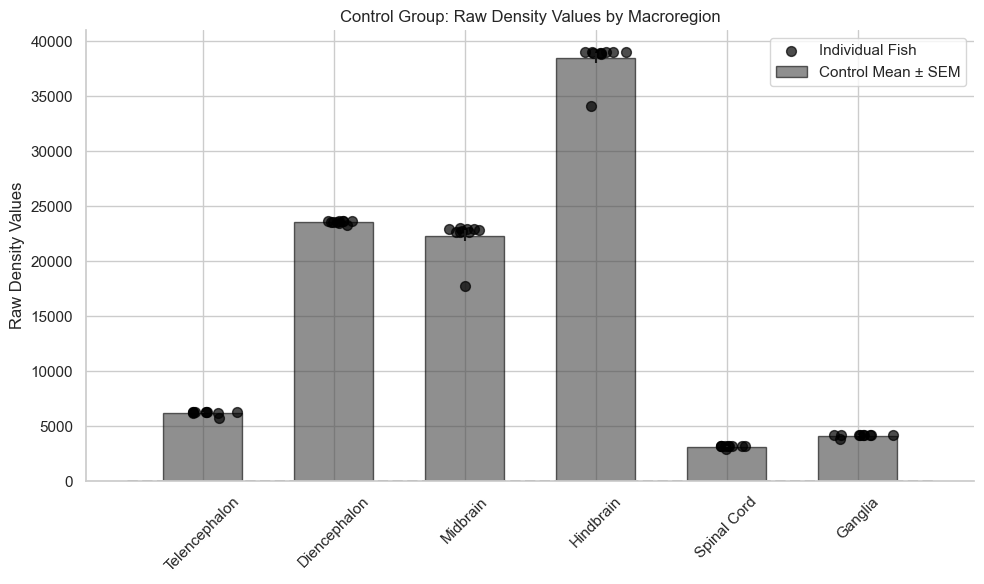

In [13]:
# Set Seaborn style
sns.set(style="whitegrid")

# Macro regions
macro_masks = ["Telencephalon", "Diencephalon", "Midbrain", "Hindbrain", "Spinal Cord", "Ganglia"]

# Define colors
bar_color = '#444444'   # Dark grey
dot_color = '#000000'   # Black

# Compute means, SEMs, and individual data
control_means = []
control_sems = []
control_scatter = {region: [] for region in macro_masks}

for macro in macro_masks:
    arrays = region_data_control.get(macro)
    if arrays:
        stacked = np.stack(arrays)  # shape (n_fish, data_points)
        region_means = np.mean(stacked, axis=1)  # mean per fish
        mean = region_means.mean()
        sem_val = sem(region_means)
        control_scatter[macro].extend(region_means)
    else:
        mean = np.nan
        sem_val = np.nan
    
    control_means.append(mean)
    control_sems.append(sem_val)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(macro_masks))
bar_width = 0.6

# Bar plot
ax.bar(x, control_means, yerr=control_sems, capsize=0, width=bar_width,
       color=bar_color, edgecolor='black', label='Control Mean ± SEM', alpha=0.6)

# Scatter plot (individual fish)
for j, region in enumerate(macro_masks):
    y_vals = control_scatter[region]
    jitter = np.random.normal(0, 0.1, size=len(y_vals))  # small jitter 
    x_vals = x[j] + jitter
    ax.scatter(x_vals, y_vals, color=dot_color, alpha=0.7, s=50,
               label='Individual Fish' if j == 0 else "")

# Final plot touches
ax.set_xticks(x)
ax.set_xticklabels(macro_masks, rotation=45)
ax.set_ylabel("Raw Density Values")
ax.set_title("Control Group: Raw Density Values by Macroregion")
ax.legend()
sns.despine(right=True, bottom=False)
plt.tight_layout()

xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linewidth=2, color='grey', linestyles='dashed')

plt.show()

# Save plot
fig.savefig(r'E:\final\final\sleep_conditions_results\controls_RAW_data_Macro.pdf')


In [14]:
for macro in macro_masks:
    arrays = region_data_control.get(macro)
    print(f"{macro}: {len(arrays) if arrays else 0} arrays")

Telencephalon: 10 arrays
Diencephalon: 10 arrays
Midbrain: 10 arrays
Hindbrain: 10 arrays
Spinal Cord: 10 arrays
Ganglia: 10 arrays


### plots of SD and control groups + Statistics Macro masks-BEFORE subtracting

##NEW

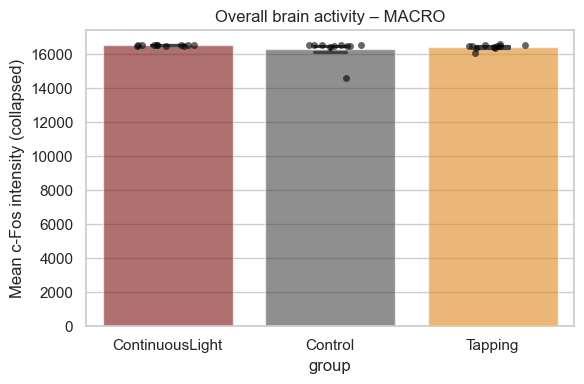

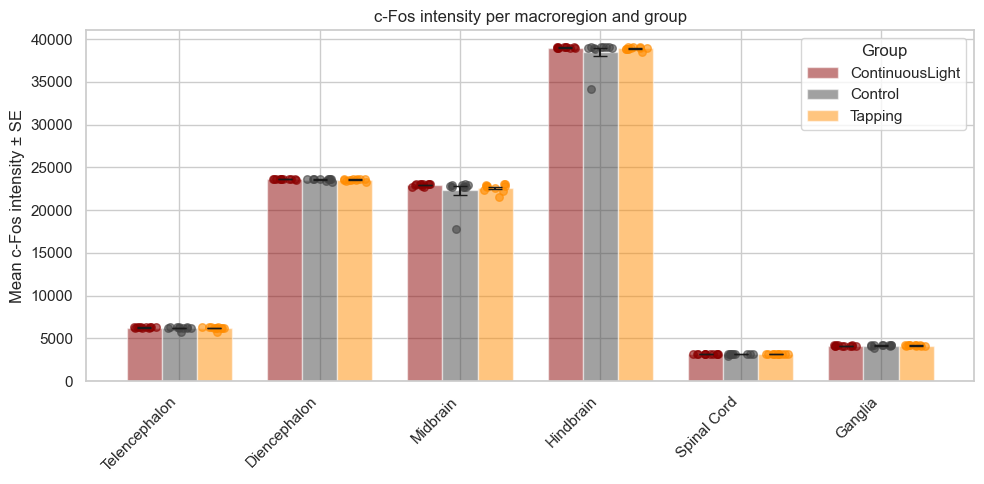

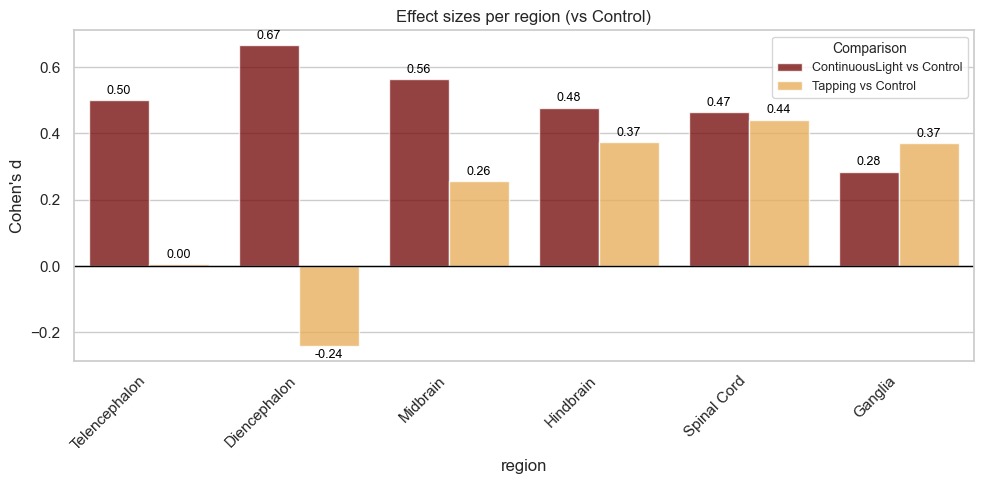

All results saved in: E:\final\final\sleep_conditions_results\Analysis_Results_LMM_GlobalFDR_CohensD.xlsx


In [20]:
# ================================================================
# FULL MACRO-MASK ANALYSIS (CONTROL VS TREATMENTS)
# ================================================================

# ================================================================
# Save directory
# ================================================================
output_dir = r"E:\final\final\sleep_conditions_results"
os.makedirs(output_dir, exist_ok=True)

# ================================================================
# STEP 0: Build long-format dataframe
# ================================================================
group_scatter_macro = {g: {region: [] for region in macro_masks} for g in ['Control','ContinuousLight','Tapping']}

for region in macro_masks:
    group_scatter_macro['Control'][region].extend([np.mean(arr) for arr in region_data_control.get(region, [])])
    for group in ['ContinuousLight','Tapping']:
        group_scatter_macro[group][region].extend([np.mean(arr) for arr in region_mean_treatment_raw.get(group, {}).get(region, [])])

all_data_macro = []
for group_name, regions_dict in group_scatter_macro.items():
    for region_name, fish_data_list in regions_dict.items():
        for i, value in enumerate(fish_data_list):
            all_data_macro.append({
                'fish_id': f"{group_name}_fish_{i+1}",
                'group': group_name,
                'region': region_name,
                'cfos_intensity': value
            })

df_results = pd.DataFrame(all_data_macro)
df_results.to_excel(os.path.join(output_dir, "raw_cfos_Intensity.xlsx"), index=False)

# ================================================================
# STEP 1: Overall brain activity ANOVA + Tukey
# ================================================================
df_avg_macro = df_results.groupby(['fish_id','group'])['cfos_intensity'].mean().reset_index()
model_macro = ols('cfos_intensity ~ C(group)', data=df_avg_macro).fit()
anova_table_macro = sm.stats.anova_lm(model_macro, typ=2)

tukey_macro = sm.stats.multicomp.pairwise_tukeyhsd(df_avg_macro['cfos_intensity'], df_avg_macro['group'])
tukey_df = pd.DataFrame(data=tukey_macro._results_table.data[1:], columns=tukey_macro._results_table.data[0])
tukey_df['Significant'] = tukey_df['reject'].apply(lambda x: 'Yes' if x else 'No')

# Plot overall brain activity
plt.figure(figsize=(6,4))
palette_dict = {'Control':'#444444','ContinuousLight':'#8B0000','Tapping':'#FF8C00'}
ax = sns.barplot(x="group", y="cfos_intensity", data=df_avg_macro,
                 palette=palette_dict, errorbar="se", capsize=0.2, dodge=False,
                 alpha=0.6, hue="group", legend=False)
sns.stripplot(x="group", y="cfos_intensity", data=df_avg_macro, color="black", alpha=0.6, ax=ax, jitter=0.2)
plt.ylabel("Mean c-Fos intensity (collapsed)")
plt.title("Overall brain activity – MACRO")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "overall_brain_activity.pdf"))
plt.show()

# ================================================================
# STEP 2: c-Fos intensity per macroregion (means ± SE + points)
# ================================================================
region_order = ['Telencephalon','Diencephalon','Midbrain','Hindbrain','Spinal Cord','Ganglia']
groups_plot = ['ContinuousLight','Control','Tapping']  # Control in the middle
palette_dict = {'Control':'#444444','ContinuousLight':'#8B0000','Tapping':'#FF8C00'}

df_region_mean = df_results.groupby(['region','group'])['cfos_intensity'].agg(['mean','sem']).reset_index()
plt.figure(figsize=(10,5))
bar_width = 0.25
x = np.arange(len(region_order))
offsets = [-bar_width, 0, bar_width]

for j, group in enumerate(groups_plot):
    means = [df_region_mean[(df_region_mean['region']==r) & (df_region_mean['group']==group)]['mean'].values[0] for r in region_order]
    sems = [df_region_mean[(df_region_mean['region']==r) & (df_region_mean['group']==group)]['sem'].values[0] for r in region_order]
    plt.bar(x + offsets[j], means, yerr=sems, width=bar_width, color=palette_dict[group],
            label=group, capsize=5, alpha=0.5)

for i, region in enumerate(region_order):
    for j, group in enumerate(groups_plot):
        vals = df_results[(df_results['region']==region) & (df_results['group']==group)]['cfos_intensity']
        jitter = 0.09
        x_positions = x[i] + offsets[j] + np.random.uniform(-jitter, jitter, size=len(vals))
        plt.scatter(x_positions, vals, color=palette_dict[group], alpha=0.6, s=30)

plt.xticks(x, region_order, rotation=45, ha='right')
plt.ylabel("Mean c-Fos intensity ± SE")
plt.title("c-Fos intensity per macroregion and group")
plt.legend(title='Group')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "cfos_per_macroregion_center_control.pdf"))
plt.show()

# ================================================================
# STEP 3: LMM region-specific contrasts + global FDR
# ================================================================
model_lmm = mixedlm("cfos_intensity ~ C(group)*C(region)",
                    data=df_results,
                    groups=df_results["fish_id"])
lmm_result = model_lmm.fit(reml=False)

params = lmm_result.params
cov = lmm_result.cov_params()

regions = df_results['region'].unique()
groups = df_results['group'].unique()

contrast_list = []

for region in regions:
    for i, g1 in enumerate(groups):
        for g2 in groups[i+1:]:
            L = np.zeros(len(params))
            if f"C(group)[T.{g1}]" in params.index:
                L[params.index.get_loc(f"C(group)[T.{g1}]")] = 1
            if f"C(group)[T.{g2}]" in params.index:
                L[params.index.get_loc(f"C(group)[T.{g2}]")] = -1
            term1 = f"C(group)[T.{g1}]:C(region)[T.{region}]"
            term2 = f"C(group)[T.{g2}]:C(region)[T.{region}]"
            if term1 in params.index:
                L[params.index.get_loc(term1)] += 1
            if term2 in params.index:
                L[params.index.get_loc(term2)] -= 1

            estimate = float(L @ params)
            se = float(np.sqrt(L @ cov @ L.T))
            t_stat = estimate / se if se > 0 else np.nan
            p_value = 2 * (1 - norm.cdf(abs(t_stat)))

            contrast_list.append({
                "region": region,
                "group1": g1,
                "group2": g2,
                "estimate_diff": estimate,
                "SE": se,
                "t_stat": t_stat,
                "p_value": p_value
            })

df_contrasts = pd.DataFrame(contrast_list)

# Global FDR correction
df_contrasts['p_adj_global'] = multipletests(df_contrasts['p_value'], method='fdr_bh')[1]
df_contrasts['Significant_global'] = df_contrasts['p_adj_global'] < 0.05


# ================================================================
# STEP 4: Standard Cohen's d (independent samples) per region
# ================================================================
def cohens_d(x, y):
    x, y = np.array(x), np.array(y)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    pooled_sd = np.sqrt(((nx-1)*np.var(x, ddof=1) + (ny-1)*np.var(y, ddof=1)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_sd

# All comparisons for Excel
all_comparisons = [('Tapping','Control'), ('ContinuousLight','Control'), ('Tapping','ContinuousLight')]
effect_sizes = []

for region in regions:
    df_region = df_results[df_results['region'] == region]
    
    for g1, g2 in all_comparisons:
        x = df_region[df_region['group'] == g1]['cfos_intensity']
        y = df_region[df_region['group'] == g2]['cfos_intensity']
        d = cohens_d(x, y)
        
        effect_sizes.append({
            'region': region,
            'comparison': f'{g1} vs {g2}',
            'Cohens_d': d
        })

df_effects_region = pd.DataFrame(effect_sizes)

# ================================================================
# Plot Cohen's d per region (only vs Control) with proper annotations
# ================================================================
plot_comparisons = ['Tapping vs Control', 'ContinuousLight vs Control']

# Filter out rows with NaN or zero Cohen's d
df_plot = df_effects_region[
    df_effects_region['comparison'].isin(plot_comparisons) &
    df_effects_region['Cohens_d'].notna() &
    (df_effects_region['Cohens_d'] != 0)
]

plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=df_plot,
    x='region',
    y='Cohens_d',
    hue='comparison',
    hue_order=['ContinuousLight vs Control','Tapping vs Control'],  # Tapping on right
    palette={'ContinuousLight vs Control':'#8B0000', 'Tapping vs Control':'#FFB347'},
    alpha=0.8
)
plt.axhline(0, color='black', linewidth=1)
plt.ylabel("Cohen's d")
plt.title("Effect sizes per region (vs Control)")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Comparison', loc='upper right', fontsize=9, title_fontsize=10)

# --- Annotate bars with numeric values, skip zeros or NaNs ---
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height) and height != 0:
        if height > 0:
            va = 'bottom'
            offset = 0.01
        else:
            va = 'top'
            offset = -0.01
        ax.annotate(f"{height:.2f}",
                    xy=(p.get_x() + p.get_width()/2, height + offset),
                    ha='center', va=va, fontsize=9, color='black')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "MACRO_cohens_d_vs_control_annotated.pdf"))
plt.show()


# ================================================================
# STEP 5: Save results to Excel
# ================================================================
excel_path = os.path.join(output_dir, "Analysis_Results_LMM_GlobalFDR_CohensD.xlsx")
with pd.ExcelWriter(excel_path) as writer:
    anova_table_macro.to_excel(writer, sheet_name="ANOVA_Overall", index=True)
    tukey_df.to_excel(writer, sheet_name="Tukey_HSD_Overall", index=False)
    df_contrasts.to_excel(writer, sheet_name="LMM_Contrasts_GlobalFDR", index=False)
    df_effects_region.to_excel(writer, sheet_name="CohensD_Standard", index=False)

print(f"All results saved in: {excel_path}")




## Plotting each individual fish after subtracting control mean per region + Performing statistical tests on those subtracted values

Region-specific contrasts saved to E:\final\final\sleep_conditions_results\region_specific_contrasts.xlsx
Figure saved to E:\final\final\sleep_conditions_results\macro_plots_subtracted_corrected.pdf


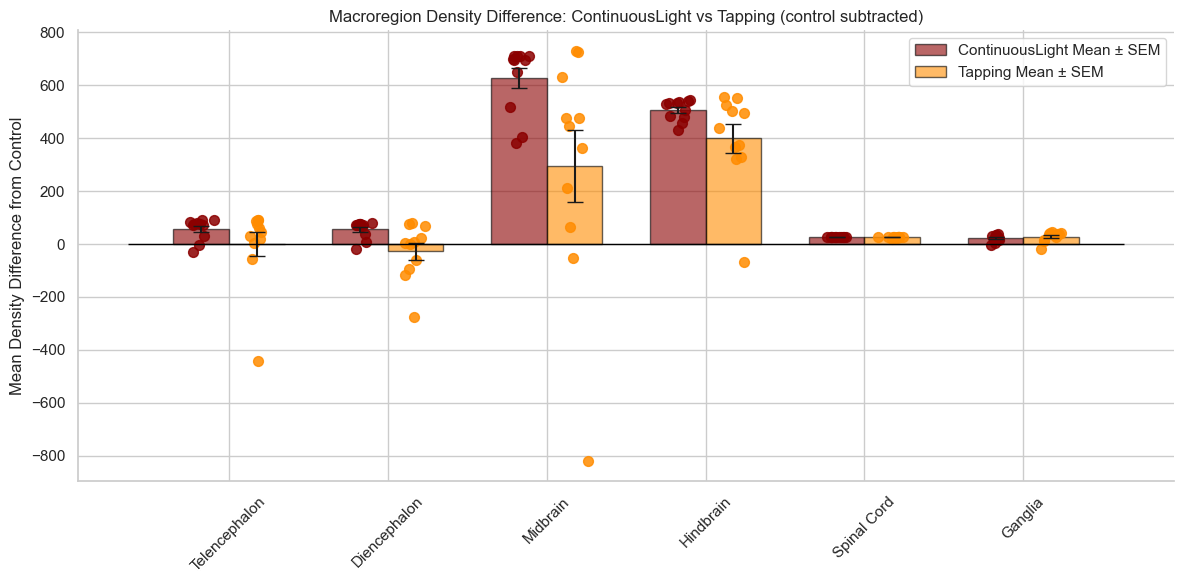

In [27]:
# ------------------------
# Region-specific contrasts: Tapping vs ContinuousLight
# ------------------------

from scipy.stats import norm, sem
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# --- 1. Region-specific contrasts from the fitted LMM ---
params = lmm_result.params
cov = lmm_result.cov_params()
param_names = params.index.tolist()

contrast_list = []

for region in macro_masks:
    L = np.zeros(len(params))

    # Main group effects
    tap_main = [i for i, p in enumerate(param_names)
                if p.startswith('C(group)[T.Tapping]')]
    cl_main  = [i for i, p in enumerate(param_names)
                if p.startswith('C(group)[T.ContinuousLight]')]
    for idx in tap_main:
        L[idx] = 1
    for idx in cl_main:
        L[idx] = -1

    # Interaction terms for this region
    term_tap = [i for i, p in enumerate(param_names)
                if p == f'C(group)[T.Tapping]:C(region)[T.{region}]']
    term_cl  = [i for i, p in enumerate(param_names)
                if p == f'C(group)[T.ContinuousLight]:C(region)[T.{region}]']
    for idx in term_tap:
        L[idx] += 1
    for idx in term_cl:
        L[idx] -= 1

    estimate = float(L @ params)
    se = float(np.sqrt(L @ cov @ L.T))
    t_stat = estimate / se if se > 0 else np.nan
    p_value = 2 * (1 - norm.cdf(abs(t_stat)))

    contrast_list.append({
        "Region": region,
        "Estimate_Diff": estimate,
        "SE": se,
        "t_stat": t_stat,
        "p_value": p_value
    })

df_contrasts = pd.DataFrame(contrast_list)

# FDR correction
df_contrasts['p_adj'] = multipletests(df_contrasts['p_value'], method='fdr_bh')[1]
df_contrasts['Significant'] = df_contrasts['p_adj'] < 0.05

# Save contrasts
contrast_file = os.path.join(output_dir, "region_specific_contrasts.xlsx")
df_contrasts.to_excel(contrast_file, index=False)
print(f"Region-specific contrasts saved to {contrast_file}")

# --- 2. Build control-subtracted data for plotting ---
group_data_subtracted = {g: {} for g in ['Tapping', 'ContinuousLight']}
for region in macro_masks:
    control_vals = np.array(group_scatter_macro['Control'][region])
    control_mean = np.mean(control_vals)
    for g in ['Tapping', 'ContinuousLight']:
        vals = np.array(group_scatter_macro[g][region])
        group_data_subtracted[g][region] = vals - control_mean

# groups to plot (we only have Tapping and ContinuousLight after subtraction)
groups_to_plot = ['ContinuousLight','Tapping']



# --- 3. Plot bars ± SEM and individual points ---
x = np.arange(len(macro_masks))
bar_width = 0.35
fig, ax = plt.subplots(figsize=(12, 6))

group_means = {
    g: [np.mean(group_data_subtracted[g][r]) if len(group_data_subtracted[g][r]) > 0 else np.nan
        for r in macro_masks]
    for g in groups_to_plot
}
group_sems = {
    g: [sem(group_data_subtracted[g][r]) if len(group_data_subtracted[g][r]) > 1
        else (0.0 if len(group_data_subtracted[g][r]) == 1 else np.nan)
        for r in macro_masks]
    for g in groups_to_plot
}

colors = ['#8B0000', '#FF8C00']  # ContinuousLight dark red, Tapping orange
for i, g in enumerate(groups_to_plot):
    offset = (i - 0.5) * bar_width
    ax.bar(x + offset, group_means[g], yerr=group_sems[g], capsize=6,
           width=bar_width, color=colors[i], edgecolor='black', alpha=0.6,
           label=f'{g} Mean ± SEM')
    # Overlay individual points
    for j, r in enumerate(macro_masks):
        y_vals = group_data_subtracted[g][r]
        if len(y_vals) > 0:
            x_vals = x[j] + offset + np.random.normal(0, 0.04, size=len(y_vals))
            ax.scatter(x_vals, y_vals, color=colors[i], alpha=0.85, s=50)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(macro_masks, rotation=45)
ax.set_ylabel("Mean Density Difference from Control")
ax.set_title("Macroregion Density Difference: ContinuousLight vs Tapping (control subtracted)")
ax.hlines(y=0, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linewidth=1, color='black')
ax.legend()
sns.despine(right=True, bottom=False)
plt.tight_layout()

# Save figure
fig_filename = os.path.join(output_dir, 'macro_plots_subtracted_corrected.pdf')
fig.savefig(fig_filename)
print(f"Figure saved to {fig_filename}")
plt.show()


# Plots Mini Masks

In [207]:
mini_masks = ["Olfactory Bulb", "Pallium", "Subpallium", "Pineal", "Habenula", "Optic Tract and Accessory Optic System", 
              "Retinal Arborization Field 1 (AF1, Approximate Location)", "Retinal Arborization Field 2 (AF2, Approximate Location)", 
              "Retinal Arborization Field 3 (AF3)", "Retinal Arborization Field 4 (AF4)", "Retinal Arborization Field 5 (AF5)", 
              "Retinal Arborization Field 6 (AF6)", "Retinal Arborization Field 7 (AF7)", "Retinal Arborization Field 8 (AF8)", 
              "Retinal Arborization Field 9 (AF9)", "Pretectum", "Dorsal Thalamus", "Ventral Thalamus", "Preoptic Area", "Posterior Tuberculum", 
              "Preglomerular Complex (approximate area)", "Rostral Hypothalamus", "Intermediate Hypothalamus", 
              "Diffuse Nucleus of the Intermediate Hypothalamus", "Caudal Hypothalamus", "Pituitary", "Torus Longitudinalis", "Torus Semicircularis", 
              "Neuropil", "Stratum Periventriculare", "Tegmentum", "Oculomotor Nucleus nIII", "NucMLF (nucleus of the medial longitudinal fascicle)", 
              "Cerebellum", "Valvula Cerebellum", "Cerebellar Corpus", "Granular Eminence", "Medial Caudal Lobe", "Rhombomere 1", "Raphe - Superior", 
              "Interpeduncular Nucleus", "Locus Coeruleus", "Rhombomere 2", "Raphe - Superior1", "Locus Coeruleus1", "Rhombomere 3", "Raphe - Inferior", 
              "Rhombomere 4", "Raphe - Inferior1", "Rhombomere 5", "Raphe - Inferior2", "Rhombomere 6", "Raphe - Inferior3", "Rhombomere 7", 
              "Raphe - Inferior4", "Caudal Hindbrain", "Area Postrema", "Inferior Olive", "Lateral Reticular Nucleus", "RoL-R1", "RoL2", "RoM1", "RoM2", 
              "RoM3", "RoL3", "RoV3", "Mauthner", "Mauthner Cell Axon Cap", "MiV1", "MiM1", "MiR1", "MiR2", "MiD2", "MiV2", "MiD3", "MiT", "CaD", "CaV", 
              "Spinal Backfill Vestibular Population", "Tangential Vestibular Nucleus", "Tangential Vestibular Nucleus1", "Medial Vestibular Nucleus", 
              "Medial Vestibular Nucleus1", "Oculomotor Nucleus nIV", "Anterior Cluster of nV Trigeminal Motorneurons", 
              "Posterior Cluster of nV Trigeminal Motorneurons", "VII Facial Motor and octavolateralis efferent neurons", 
              "VII Facial Motor and octavolateralis efferent neurons1", "VII Facial Motor and octavolateralis efferent neurons2", 
              "X Vagus motorneuron cluster", "Olfactory Epithelium", "Facial Sensory Ganglion", "Facial glossopharyngeal ganglion", 
              "Statoacoustic Ganglion", "Trigeminal Ganglion", "Anterior Lateral Line Ganglion", "Posterior Lateral Line Ganglia", "Lateral Line Neuromast D1",
              "Lateral Line Neuromast D2", "Lateral Line Neuromast N", "Lateral Line Neuromast O1", "Lateral Line Neuromast OC1", "Lateral Line Neuromast SO1",
              "Lateral Line Neuromast SO2", "Lateral Line Neuromast SO3", "Vagal Ganglia"]

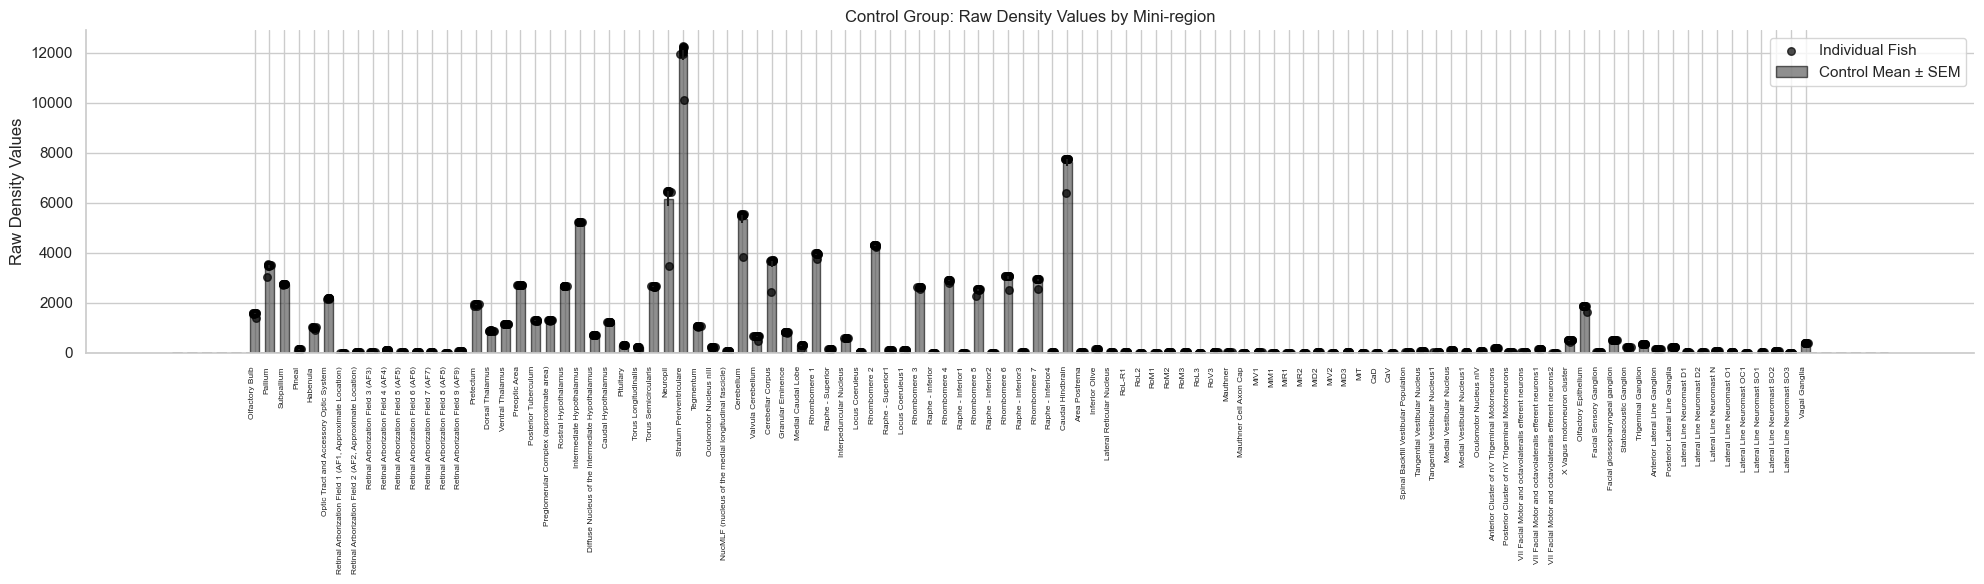

In [208]:
#ALL RAW CONTROL REGIONS

# -------------------------------
# User settings
# -------------------------------
control_dir = r"E:\final\final\controls_SD"  # folder with raw per-fish mini-region files
control_files = [f for f in os.listdir(control_dir) if f.endswith(".pkl")]

mini_masks = ["Olfactory Bulb", "Pallium", "Subpallium", "Pineal", "Habenula", "Optic Tract and Accessory Optic System", 
              "Retinal Arborization Field 1 (AF1, Approximate Location)", "Retinal Arborization Field 2 (AF2, Approximate Location)", 
              "Retinal Arborization Field 3 (AF3)", "Retinal Arborization Field 4 (AF4)", "Retinal Arborization Field 5 (AF5)", 
              "Retinal Arborization Field 6 (AF6)", "Retinal Arborization Field 7 (AF7)", "Retinal Arborization Field 8 (AF8)", 
              "Retinal Arborization Field 9 (AF9)", "Pretectum", "Dorsal Thalamus", "Ventral Thalamus", "Preoptic Area", "Posterior Tuberculum", 
              "Preglomerular Complex (approximate area)", "Rostral Hypothalamus", "Intermediate Hypothalamus", 
              "Diffuse Nucleus of the Intermediate Hypothalamus", "Caudal Hypothalamus", "Pituitary", "Torus Longitudinalis", "Torus Semicircularis", 
              "Neuropil", "Stratum Periventriculare", "Tegmentum", "Oculomotor Nucleus nIII", "NucMLF (nucleus of the medial longitudinal fascicle)", 
              "Cerebellum", "Valvula Cerebellum", "Cerebellar Corpus", "Granular Eminence", "Medial Caudal Lobe", "Rhombomere 1", "Raphe - Superior", 
              "Interpeduncular Nucleus", "Locus Coeruleus", "Rhombomere 2", "Raphe - Superior1", "Locus Coeruleus1", "Rhombomere 3", "Raphe - Inferior", 
              "Rhombomere 4", "Raphe - Inferior1", "Rhombomere 5", "Raphe - Inferior2", "Rhombomere 6", "Raphe - Inferior3", "Rhombomere 7", 
              "Raphe - Inferior4", "Caudal Hindbrain", "Area Postrema", "Inferior Olive", "Lateral Reticular Nucleus", "RoL-R1", "RoL2", "RoM1", "RoM2", 
              "RoM3", "RoL3", "RoV3", "Mauthner", "Mauthner Cell Axon Cap", "MiV1", "MiM1", "MiR1", "MiR2", "MiD2", "MiV2", "MiD3", "MiT", "CaD", "CaV", 
              "Spinal Backfill Vestibular Population", "Tangential Vestibular Nucleus", "Tangential Vestibular Nucleus1", "Medial Vestibular Nucleus", 
              "Medial Vestibular Nucleus1", "Oculomotor Nucleus nIV", "Anterior Cluster of nV Trigeminal Motorneurons", 
              "Posterior Cluster of nV Trigeminal Motorneurons", "VII Facial Motor and octavolateralis efferent neurons", 
              "VII Facial Motor and octavolateralis efferent neurons1", "VII Facial Motor and octavolateralis efferent neurons2", 
              "X Vagus motorneuron cluster", "Olfactory Epithelium", "Facial Sensory Ganglion", "Facial glossopharyngeal ganglion", 
              "Statoacoustic Ganglion", "Trigeminal Ganglion", "Anterior Lateral Line Ganglion", "Posterior Lateral Line Ganglia", "Lateral Line Neuromast D1",
              "Lateral Line Neuromast D2", "Lateral Line Neuromast N", "Lateral Line Neuromast O1", "Lateral Line Neuromast OC1", "Lateral Line Neuromast SO1",
              "Lateral Line Neuromast SO2", "Lateral Line Neuromast SO3", "Vagal Ganglia"]
# -------------------------------
# Load data
# -------------------------------
region_data_control_mini = {mini: [] for mini in mini_masks}

for file in control_files:
    file_path = os.path.join(control_dir, file)
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    
    if isinstance(data, dict):
        for name, arr in data.items():
            arr = np.array(arr)
            if name in mini_masks and arr.size > 0:
                region_data_control_mini[name].append(arr)
    elif isinstance(data, list) and len(data) > 0:
        if isinstance(data[0], dict):
            for region in data:
                name = region.get("region_name")
                arr = np.array(region.get("density_plt", []))
                if name in mini_masks and arr.size > 0:
                    region_data_control_mini[name].append(arr)
        elif isinstance(data[0], tuple):
            for name, arr in data:
                arr = np.array(arr)
                if name in mini_masks and arr.size > 0:
                    region_data_control_mini[name].append(arr)

# -------------------------------
# Filter out empty regions
# -------------------------------
mini_masks_with_data = [m for m in mini_masks if len(region_data_control_mini[m]) > 0]

control_means = []
control_sems = []
control_scatter = {}

for mini in mini_masks_with_data:
    arrays = region_data_control_mini[mini]
    stacked = np.stack(arrays)
    region_means = np.mean(stacked, axis=1)
    control_means.append(region_means.mean())
    control_sems.append(sem(region_means))
    control_scatter[mini] = region_means

# -------------------------------
# Plotting
# -------------------------------
sns.set(style="whitegrid")
bar_color = "#444444"
dot_color = "#000000"

fig, ax = plt.subplots(figsize=(20, 6))
x = np.arange(len(mini_masks_with_data))
bar_width = 0.6

# Bars
ax.bar(x, control_means, yerr=control_sems, capsize=0, width=bar_width,
       color=bar_color, edgecolor="black", alpha=0.6, label="Control Mean ± SEM")

# Individual points
for j, region in enumerate(mini_masks_with_data):
    y_vals = control_scatter[region]
    jitter = np.random.normal(0, 0.08, size=len(y_vals))
    ax.scatter(x[j]+jitter, y_vals, color=dot_color, s=30, alpha=0.7,
               label="Individual Fish" if j==0 else "")

# Labels
ax.set_xticks(x)
ax.set_xticklabels(mini_masks_with_data, rotation=90, fontsize=6, ha="right")
ax.set_ylabel("Raw Density Values")
ax.set_title("Control Group: Raw Density Values by Mini-region")
ax.legend()
sns.despine(right=True, bottom=False)
plt.tight_layout()

xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, linewidth=2, color="grey", linestyles="dashed")

plt.show()

# Save
fig.savefig(r"E:\final\final\sleep_conditions_results\controls_RAW_data_Mini.pdf")


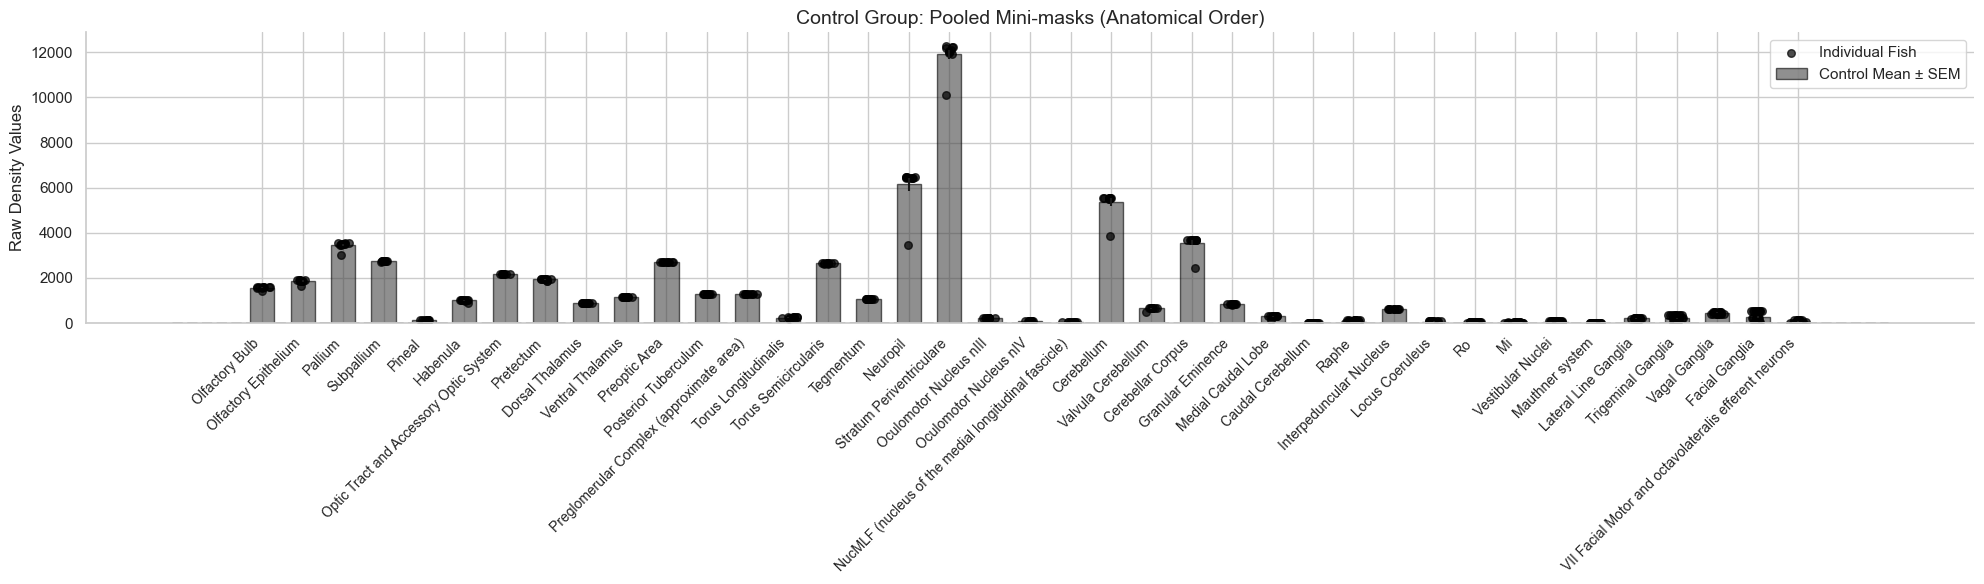

In [209]:
##POOL Regions

# -------------------------------
# User settings
# -------------------------------
control_dir = r"E:\final\final\controls_SD"
output_file = r"E:\final\final\sleep_conditions_results\controls_RAW_data_pooled_mini_afterpooling.pdf"

control_files = [f for f in os.listdir(control_dir) if f.endswith(".pkl")]

# -------------------------------
# Load control mini-mask data
# -------------------------------
region_data_control_mini = {}

for file in control_files:
    file_path = os.path.join(control_dir, file)
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    if isinstance(data, dict):
        for name, arr in data.items():
            region_data_control_mini.setdefault(name, []).append(np.array(arr))
    elif isinstance(data, list):
        for entry in data:
            if isinstance(entry, dict):
                name = entry.get("region_name")
                arr = np.array(entry.get("density_plt", []))
                region_data_control_mini.setdefault(name, []).append(arr)
            elif isinstance(entry, tuple):
                name, arr = entry
                region_data_control_mini.setdefault(name, []).append(np.array(arr))

# -------------------------------
# Define pooling rules
# -------------------------------
def get_base_name(name):
    # Classic pools
    if "Retinal Arborization Field" in name:
        return "Retinal Arborization Field "
    if "Lateral Line Neuromast" in name:
        return "Lateral Line Neuromast "
    if "Facial Motor and octavolateralis" in name:
        return "VII Facial Motor and octavolateralis efferent neurons"
    if "Rhombomere" in name:
        return "Rhombomere "
    if "Raphe" in name:
        return "Raphe"

    # Mi regions pooled
    if name in ("MiD2", "MiD3", "MiV1", "MiV2", "MiR1", "MiR2", "MiM1", "MiT"):
        return "Mi"

    # Ro regions pooled
    if name in ("RoL-R1", "RoL2", "RoL3", "RoM1", "RoM2", "RoM3", "RoV3"):
        return "Ro"

    # Locus Coeruleus
    if name.startswith("Locus Coeruleus"):
        return "Locus Coeruleus"

    # Vestibular nuclei
    if name in ("Tangential Vestibular Nucleus", "Tangential Vestibular Nucleus1",
                "Medial Vestibular Nucleus", "Medial Vestibular Nucleus1",
                "Spinal Backfill Vestibular Population"):
        return "Vestibular Nuclei"

    # Mauthner system
    if name in ("Mauthner", "Mauthner Cell Axon Cap"):
        return "Mauthner system"

    # Ganglia pools
    if name in ("Anterior Cluster of nV Trigeminal Motorneurons",
                "Posterior Cluster of nV Trigeminal Motorneurons",
                "Trigeminal Ganglion"):
        return "Trigeminal Ganglia"
    if name in ("Vagal Ganglia", "X Vagus motorneuron cluster"):
        return "Vagal Ganglia"
    if name in ("Facial Sensory Ganglion", "Facial glossopharyngeal ganglion",
                "Statoacoustic Ganglion"):
        return "Facial Ganglia"
    if name in ("Anterior Lateral Line Ganglion", "Posterior Lateral Line Ganglia"):
        return "Lateral Line Ganglia"

    # Caudal Cerebellum
    if name in ("CaD", "CaV"):
        return "Caudal Cerebellum"

    # Default: keep original name
    return name

# -------------------------------
# Pool data by base name
# -------------------------------
pooled_data = {}
used_names = set()

for mini in region_data_control_mini.keys():
    base_name = get_base_name(mini)
    if base_name in used_names:
        continue
    similar = [m for m in region_data_control_mini.keys() if get_base_name(m) == base_name]
    combined_arrays = []
    for s in similar:
        combined_arrays.extend(region_data_control_mini[s])
        used_names.add(s)
    if combined_arrays:
        stacked = np.stack(combined_arrays)
        pooled_data[base_name] = np.mean(stacked, axis=1)

# -------------------------------
# Define anatomical order
# -------------------------------
anatomical_order = [
    "Olfactory Bulb", "Olfactory Epithelium",
    "Pallium", "Subpallium",
    "Pineal", "Habenula",
    "Optic Tract and Accessory Optic System",
    "Retinal Arborization Field",
    "Pretectum", "Dorsal Thalamus", "Ventral Thalamus", "Preoptic Area",
    "Posterior Tuberculum", "Preglomerular Complex (approximate area)",
    "Torus Longitudinalis", "Torus Semicircularis", "Tegmentum", "Neuropil", "Stratum Periventriculare",
    "Oculomotor Nucleus nIII", "Oculomotor Nucleus nIV", "NucMLF (nucleus of the medial longitudinal fascicle)",
    "Cerebellum", "Valvula Cerebellum", "Cerebellar Corpus", "Granular Eminence", "Medial Caudal Lobe",
    "Caudal Cerebellum",
    "Rhombomere",
    "Raphe",
    "Interpeduncular Nucleus", "Locus Coeruleus",
    "Ro",  
    "Mi",  
    "Vestibular Nuclei",
    "Mauthner system",
    "Lateral Line Ganglia",
    "Trigeminal Ganglia",
    "Vagal Ganglia",
    "Facial Ganglia",
    "VII Facial Motor and octavolateralis efferent neurons"
]

# -------------------------------
# Keep only regions that exist in pooled_data
# -------------------------------
plot_order = [r for r in anatomical_order if r in pooled_data]

# -------------------------------
# Compute mean ± SEM
# -------------------------------
pooled_means = [pooled_data[r].mean() for r in plot_order]
pooled_sems = [sem(pooled_data[r]) for r in plot_order]

# -------------------------------
# Plot
# -------------------------------
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
x = np.arange(len(plot_order))
bar_width = 0.6

# Bars
ax.bar(x, pooled_means, yerr=pooled_sems, capsize=0, width=bar_width,
       color="#444444", edgecolor="black", alpha=0.6, label="Control Mean ± SEM")

# Individual points
for j, region in enumerate(plot_order):
    y_vals = pooled_data[region]
    jitter = np.random.normal(0, 0.08, size=len(y_vals))
    ax.scatter(x[j]+jitter, y_vals, color="black", s=30, alpha=0.7,
               label="Individual Fish" if j==0 else "")

ax.set_xticks(x)
ax.set_xticklabels(plot_order, rotation=45, fontsize=10, ha="right")  # Increased fontsize
ax.set_ylabel("Raw Density Values", fontsize=12)
ax.set_title("Control Group: Pooled Mini-masks (Anatomical Order)", fontsize=14)
ax.legend()
sns.despine(right=True, bottom=False)
plt.tight_layout()
ax.hlines(y=0, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
          linewidth=2, color="grey", linestyles="dashed")

# Save
fig.savefig(output_file)
plt.show()


## Plotting data before subtracting the control mean + performing statistical test on the subtracted values

All results saved to E:\final\final\sleep_conditions_results\LMM_full_results.xlsx


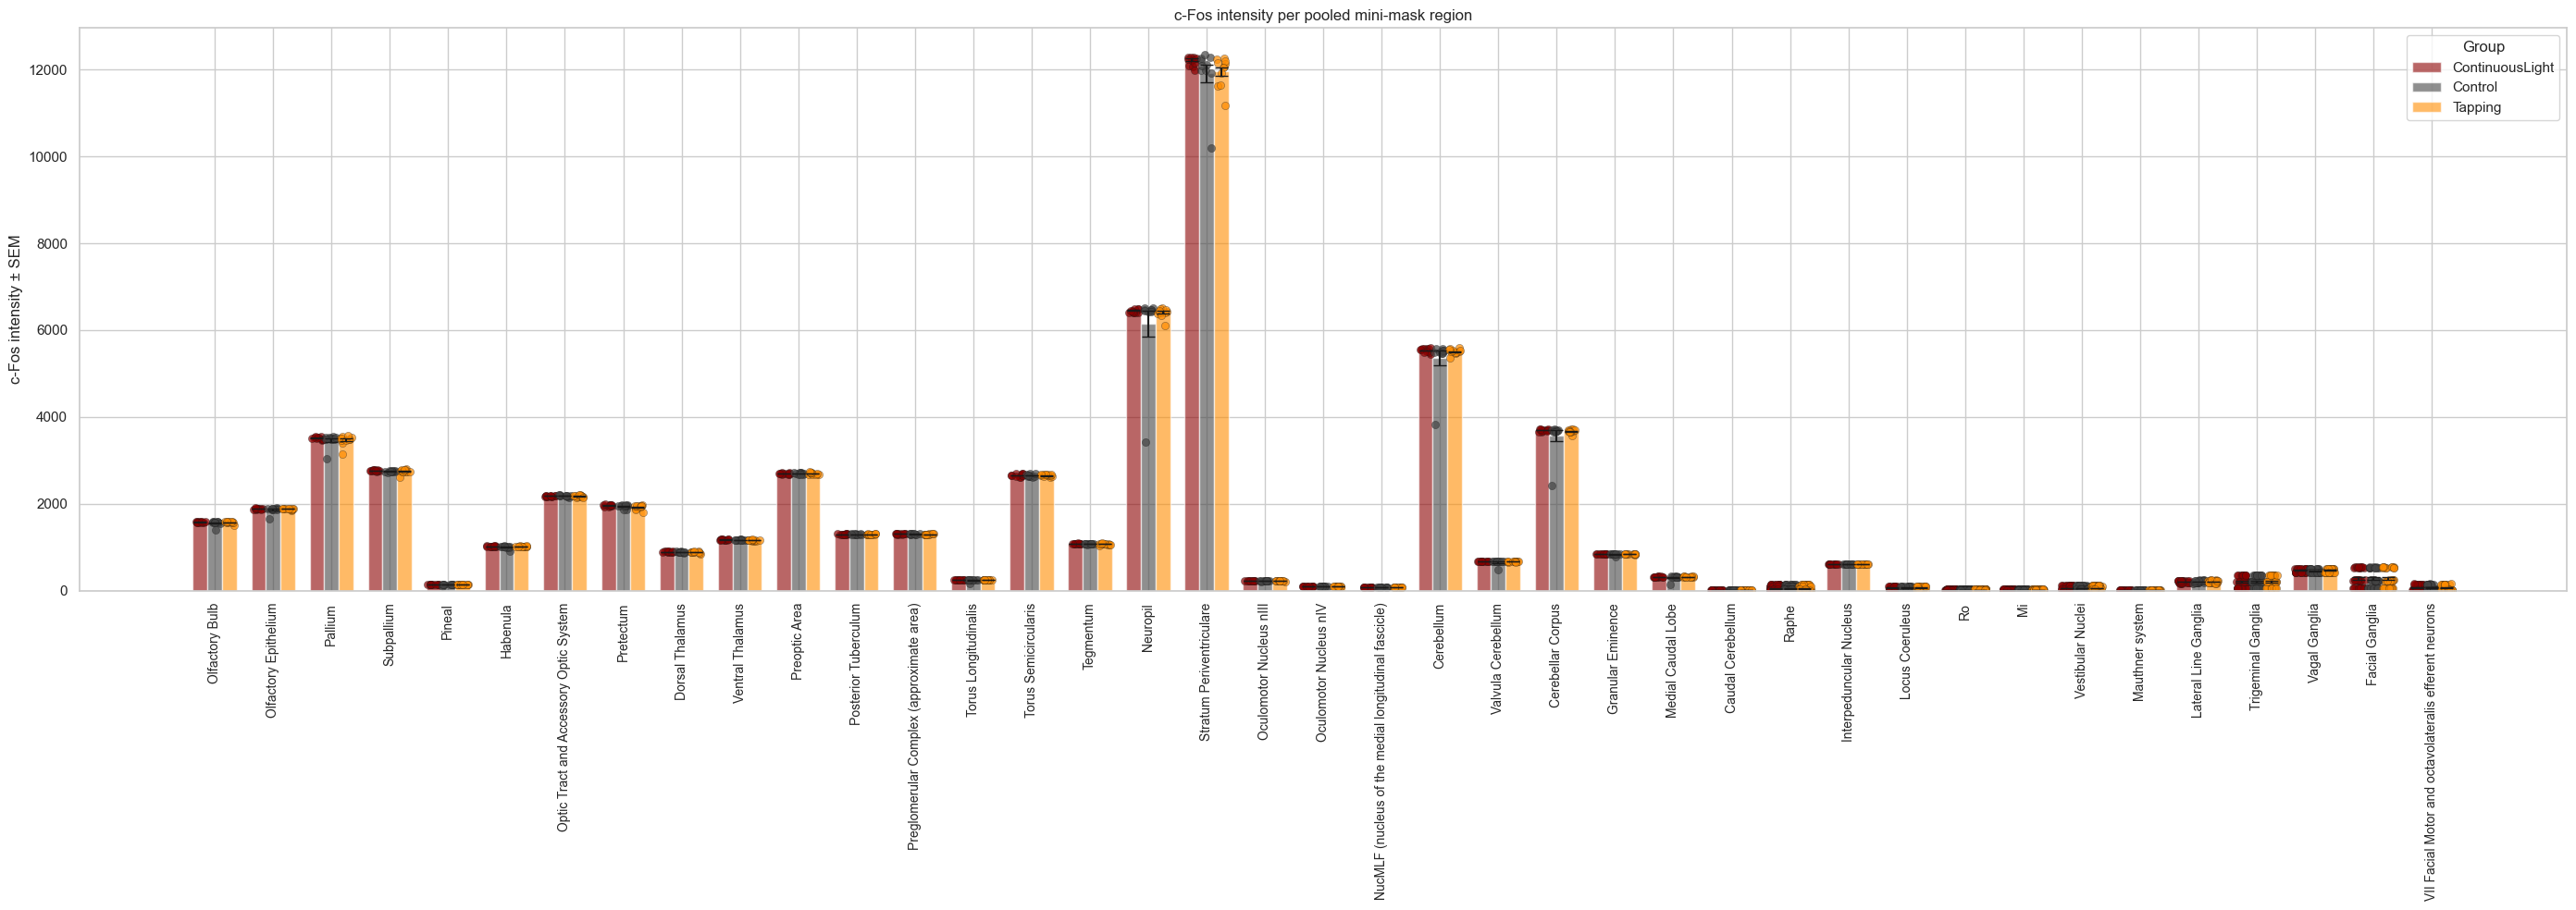

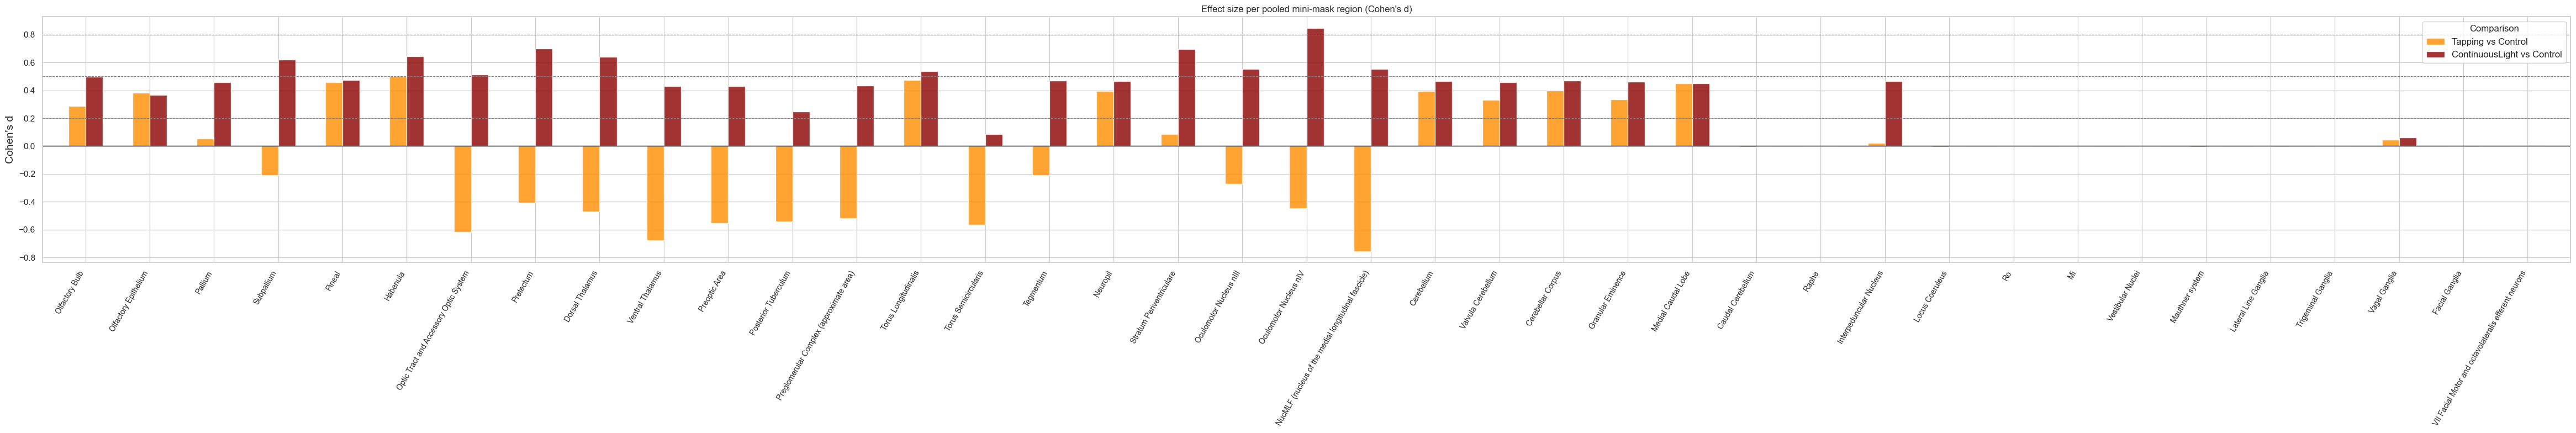

In [210]:
# ================================================================
# FULL MINI-MASK ANALYSIS (CONTROL VS TREATMENTS)
# ================================================================

# ================================================================
# User settings
# ================================================================
output_dir = r"E:\final\final\sleep_conditions_results"
os.makedirs(output_dir, exist_ok=True)

control_dir = r"E:\final\final\controls_SD"
exp_dir = r"E:\final\final\sleep_conditions"  # Contains Tapping & ContinuousLight

# ================================================================
# Pooling rules for mini-masks
# ================================================================
def get_base_name(name):
    # Classic pools
    if "Retinal Arborization Field" in name:
        return "Retinal Arborization Field "
    if "Lateral Line Neuromast" in name:
        return "Lateral Line Neuromast "
    if "Facial Motor and octavolateralis" in name:
        return "VII Facial Motor and octavolateralis efferent neurons"
    if "Rhombomere" in name:
        return "Rhombomere "
    if "Raphe" in name:
        return "Raphe"

    # Mi regions pooled
    if name in ("MiD2", "MiD3", "MiV1", "MiV2", "MiR1", "MiR2", "MiM1", "MiT"):
        return "Mi"

    # Ro regions pooled
    if name in ("RoL-R1", "RoL2", "RoL3", "RoM1", "RoM2", "RoM3", "RoV3"):
        return "Ro"

    # Locus Coeruleus
    if name.startswith("Locus Coeruleus"):
        return "Locus Coeruleus"

    # Vestibular nuclei
    if name in ("Tangential Vestibular Nucleus", "Tangential Vestibular Nucleus1",
                "Medial Vestibular Nucleus", "Medial Vestibular Nucleus1",
                "Spinal Backfill Vestibular Population"):
        return "Vestibular Nuclei"

    # Mauthner system
    if name in ("Mauthner", "Mauthner Cell Axon Cap"):
        return "Mauthner system"

    # Ganglia pools
    if name in ("Anterior Cluster of nV Trigeminal Motorneurons",
                "Posterior Cluster of nV Trigeminal Motorneurons",
                "Trigeminal Ganglion"):
        return "Trigeminal Ganglia"
    if name in ("Vagal Ganglia", "X Vagus motorneuron cluster"):
        return "Vagal Ganglia"
    if name in ("Facial Sensory Ganglion", "Facial glossopharyngeal ganglion",
                "Statoacoustic Ganglion"):
        return "Facial Ganglia"
    if name in ("Anterior Lateral Line Ganglion", "Posterior Lateral Line Ganglia"):
        return "Lateral Line Ganglia"

    # Caudal Cerebellum
    if name in ("CaD", "CaV"):
        return "Caudal Cerebellum"

    # Default: keep original name
    return name

# ================================================================
# Load & pool mini-mask data
# ================================================================
def load_and_pool_group(folder_path, single_file=None):
    pooled_group = {}
    files_to_load = [single_file] if single_file else os.listdir(folder_path)
    for file in files_to_load:
        if not file.endswith(".pkl"): continue
        file_path = os.path.join(folder_path, file)
        with open(file_path, "rb") as f:
            data = pickle.load(f)
        for entry in (data.items() if isinstance(data, dict) else data):
            if isinstance(entry, tuple):
                name, arr = entry
            elif isinstance(entry, dict):
                name = entry.get("region_name")
                arr = entry.get("density_plt", [])
            else:
                continue
            pooled_group.setdefault(name, []).append(np.array(arr))

    # Pool by base name
    pooled_data_group = {}
    used_names = set()
    for mini in pooled_group.keys():
        if mini in used_names: continue
        base_name = get_base_name(mini)
        similar = [m for m in pooled_group.keys() if get_base_name(m) == base_name]
        combined_arrays = []
        for s in similar:
            combined_arrays.extend(pooled_group[s])
            used_names.add(s)
        if combined_arrays:
            stacked = np.stack(combined_arrays)
            pooled_data_group[base_name] = np.mean(stacked, axis=1)
    return pooled_data_group

# ================================================================
# Load control & experimental groups
# ================================================================
all_pooled = {}
all_pooled['Control'] = load_and_pool_group(control_dir)

pooled_exp = {'Tapping': {}, 'ContinuousLight': {}}
for file in os.listdir(exp_dir):
    if not file.endswith(".pkl"): continue
    file_lower = file.lower()
    if "tapping" in file_lower:
        group_name = 'Tapping'
    elif "continuous" in file_lower or "cl" in file_lower:
        group_name = 'ContinuousLight'
    else:
        continue

    file_data = load_and_pool_group(exp_dir, single_file=file)
    for region, arr in file_data.items():
        if region not in pooled_exp[group_name]:
            pooled_exp[group_name][region] = arr
        else:
            pooled_exp[group_name][region] = np.concatenate([pooled_exp[group_name][region], arr])

# Merge experimental groups
for group_name, pdata in pooled_exp.items():
    all_pooled[group_name] = pdata

# ================================================================
# Build long-format DataFrame
# ================================================================
all_data = []
for group, pdata in all_pooled.items():
    for region, arr in pdata.items():
        for i, val in enumerate(arr):
            all_data.append({
                "fish_id": f"{group}_fish_{i+1}",
                "group": group,
                "region": region,
                "cfos_intensity": val
            })
df_results = pd.DataFrame(all_data)

#========================
# -------------------------------
# Define anatomical order
# -------------------------------
anatomical_order = [
    "Olfactory Bulb", "Olfactory Epithelium",
    "Pallium", "Subpallium",
    "Pineal", "Habenula",
    "Optic Tract and Accessory Optic System",
    "Retinal Arborization Field",
    "Pretectum", "Dorsal Thalamus", "Ventral Thalamus", "Preoptic Area",
    "Posterior Tuberculum", "Preglomerular Complex (approximate area)",
    "Torus Longitudinalis", "Torus Semicircularis", "Tegmentum", "Neuropil", "Stratum Periventriculare",
    "Oculomotor Nucleus nIII", "Oculomotor Nucleus nIV", "NucMLF (nucleus of the medial longitudinal fascicle)",
    "Cerebellum", "Valvula Cerebellum", "Cerebellar Corpus", "Granular Eminence", "Medial Caudal Lobe",
    "Caudal Cerebellum",
    "Rhombomere",
    "Raphe",
    "Interpeduncular Nucleus", "Locus Coeruleus",
    "Ro", 
    "Mi",  
    "Vestibular Nuclei", 
    "Mauthner system",
    "Lateral Line Ganglia",
    "Trigeminal Ganglia",
    "Vagal Ganglia",
    "Facial Ganglia",
    "VII Facial Motor and octavolateralis efferent neurons"
]

plot_order = [r for r in anatomical_order if r in pooled_data]

df_results = df_results[df_results['region'].isin(mini_mask_regions)].copy()
for group in all_pooled:
    all_pooled[group] = {r: arr for r, arr in all_pooled[group].items() if r in mini_mask_regions}

# ================================================================
# Linear Mixed Model ANOVA
# ================================================================
model_lmm = mixedlm("cfos_intensity ~ C(group) * C(region)", 
                    data=df_results, 
                    groups=df_results["fish_id"])
lmm_result = model_lmm.fit(reml=False)

# ================================================================
# Region-specific contrasts
# ================================================================
regions = df_results['region'].unique()
groups = df_results['group'].unique()
params = lmm_result.params
cov = lmm_result.cov_params()
contrast_list = []

for region in regions:
    for g1 in groups:
        for g2 in groups:
            if g1 >= g2: continue
            L = np.zeros(len(params))
            if f"C(group)[T.{g1}]" in params.index: L[params.index.get_loc(f"C(group)[T.{g1}]")] = 1
            if f"C(group)[T.{g2}]" in params.index: L[params.index.get_loc(f"C(group)[T.{g2}]")] = -1
            term1 = f"C(group)[T.{g1}]:C(region)[T.{region}]"
            term2 = f"C(group)[T.{g2}]:C(region)[T.{region}]"
            if term1 in params.index: L[params.index.get_loc(term1)] += 1
            if term2 in params.index: L[params.index.get_loc(term2)] -= 1
            estimate = L @ params
            se = np.sqrt(L @ cov @ L.T)
            t_stat = estimate / se
            p_value = 2 * (1 - norm.cdf(abs(t_stat)))
            contrast_list.append({
                "region": region, "group1": g1, "group2": g2,
                "estimate_diff": estimate, "t_stat": t_stat, "p_value": p_value
            })

df_contrasts = pd.DataFrame(contrast_list)
df_contrasts['p_adj'] = multipletests(df_contrasts['p_value'], method='fdr_bh')[1]
df_contrasts['Significant'] = df_contrasts['p_adj'] < 0.05

# ================================================================
# Cohen's d per region
# ================================================================
def cohens_d(x, y):
    x, y = np.asarray(x), np.asarray(y)
    nx, ny = len(x), len(y)
    if nx<2 or ny<2: return np.nan
    pooled_sd = np.sqrt(((nx-1)*np.var(x, ddof=1) + (ny-1)*np.var(y, ddof=1))/(nx+ny-2))
    return (np.mean(x)-np.mean(y))/pooled_sd if pooled_sd>0 else np.nan

per_region_list = []
for region in mini_mask_regions:
    ctrl = df_results[(df_results['group']=='Control') & (df_results['region']==region)]['cfos_intensity']
    tap = df_results[(df_results['group']=='Tapping') & (df_results['region']==region)]['cfos_intensity']
    cl = df_results[(df_results['group']=='ContinuousLight') & (df_results['region']==region)]['cfos_intensity']
    per_region_list.append({'region':region,'comparison':'Tapping vs Control','Cohens_d':cohens_d(tap, ctrl)})
    per_region_list.append({'region':region,'comparison':'ContinuousLight vs Control','Cohens_d':cohens_d(cl, ctrl)})

df_effects_region = pd.DataFrame(per_region_list)

# ================================================================
# Save results
# ================================================================
excel_path = os.path.join(output_dir, "LMM_full_results.xlsx")
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    df_contrasts.to_excel(writer, sheet_name='All_Contrasts', index=False)
    pd.DataFrame({
        'Parameter': lmm_result.params.index,
        'Estimate': lmm_result.params.values,
        'StdError': lmm_result.bse.values,
        't_value': lmm_result.tvalues,
        'p_value': lmm_result.pvalues
    }).to_excel(writer, sheet_name='LMM_Parameters', index=False)
    df_contrasts[df_contrasts['Significant']].to_excel(writer, sheet_name='Significant_Contrasts', index=False)
    df_effects_region.to_excel(writer, sheet_name="Cohens_d", index=False)

print(f"All results saved to {excel_path}")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# ================================================================
# Settings
# ================================================================
output_dir = r"E:\final\final\sleep_conditions_results"
os.makedirs(output_dir, exist_ok=True)
anatomical_order = [
    "Olfactory Bulb", "Olfactory Epithelium",
    "Pallium", "Subpallium",
    "Pineal", "Habenula",
    "Optic Tract and Accessory Optic System",
    "Retinal Arborization Field",
    "Pretectum", "Dorsal Thalamus", "Ventral Thalamus", "Preoptic Area",
    "Posterior Tuberculum", "Preglomerular Complex (approximate area)",
    "Torus Longitudinalis", "Torus Semicircularis", "Tegmentum", "Neuropil", "Stratum Periventriculare",
    "Oculomotor Nucleus nIII", "Oculomotor Nucleus nIV", "NucMLF (nucleus of the medial longitudinal fascicle)",
    "Cerebellum", "Valvula Cerebellum", "Cerebellar Corpus", "Granular Eminence", "Medial Caudal Lobe",
    "Caudal Cerebellum",
    "Rhombomere",
    "Raphe",
    "Interpeduncular Nucleus", "Locus Coeruleus",
    "Ro",  
    "Mi",  
    "Vestibular Nuclei",  
    "Mauthner system",
    "Lateral Line Ganglia",
    "Trigeminal Ganglia",
    "Vagal Ganglia",
    "Facial Ganglia",
    "VII Facial Motor and octavolateralis efferent neurons"
]

plot_order = [r for r in anatomical_order if r in pooled_data]

groups = ['ContinuousLight','Control','Tapping']
palette_dict = {'Control':'#444444','ContinuousLight':'#8B0000','Tapping':'#FF8C00'}

# ================================================================
# c-Fos Intensity Plot (Mean ± SEM)
# ================================================================
df_region_mean = df_results.groupby(['region','group'])['cfos_intensity'].agg(['mean','sem']).reset_index()
x = np.arange(len(plot_order))
bar_width = 0.25
offsets = [-bar_width,0,bar_width]

plt.figure(figsize=(28,10))

# Bars + Error bars
for j, group in enumerate(groups):
    means = [df_region_mean[(df_region_mean['region']==r) & (df_region_mean['group']==group)]['mean'].values[0]
             if len(df_region_mean[(df_region_mean['region']==r) & (df_region_mean['group']==group)])>0 else 0
             for r in plot_order]
    sems = [df_region_mean[(df_region_mean['region']==r) & (df_region_mean['group']==group)]['sem'].values[0]
            if len(df_region_mean[(df_region_mean['region']==r) & (df_region_mean['group']==group)])>0 else 0
            for r in plot_order]
    plt.bar(x+offsets[j], means, yerr=sems, width=bar_width, color=palette_dict[group],
            alpha=0.6, capsize=5, label=group)

# Scatter points (individual fish)
for i, region in enumerate(plot_order):
    for j, group in enumerate(groups):
        vals = df_results[(df_results['region']==region) & (df_results['group']==group)]['cfos_intensity']
        n = len(vals)
        if n==0: continue
        jitter = 0.10
        x_positions = x[i] + offsets[j] + np.random.uniform(-jitter,jitter,size=n)
        y_positions = vals + np.random.uniform(-0.01*np.max(vals), 0.01*np.max(vals), size=n)
        plt.scatter(x_positions, y_positions, color=palette_dict[group], alpha=0.7, s=35,
                    edgecolor='k', linewidth=0.3)

plt.xticks(x, plot_order, rotation=90, fontsize=10)
plt.ylabel("c-Fos intensity ± SEM")
plt.title("c-Fos intensity per pooled mini-mask region")
plt.legend(title='Group')
plt.tight_layout()
plt.savefig(os.path.join(output_dir,"cfos_intensity_pooled.pdf"))
plt.show()

# ================================================================
# Cohen's d Plot
# ================================================================
num_regions = len(plot_order)
bar_width = 0.4
x = np.arange(num_regions)*1.5
comparisons = ['Tapping vs Control','ContinuousLight vs Control']
palette = {'Tapping vs Control':'#FF8C00','ContinuousLight vs Control':'#8B0000'}

plt.figure(figsize=(max(20,num_regions*1.2),8))

for i, region in enumerate(plot_order):
    for j, comp in enumerate(comparisons):
        val = df_effects_region[(df_effects_region['region']==region) &
                                (df_effects_region['comparison']==comp)]['Cohens_d'].values
        if len(val)==0: continue
        offset = (j-0.5)*bar_width
        plt.bar(x[i]+offset, val[0], width=bar_width, color=palette[comp], alpha=0.8,
                label=comp if i==0 else "")

plt.axhline(0,color='black',linestyle='-',linewidth=1)
for h in [0.2,0.5,0.8]:
    plt.axhline(h,color='gray',linestyle='--',linewidth=0.8)

plt.ylabel("Cohen's d", fontsize=14)
plt.title("Effect size per pooled mini-mask region (Cohen's d)")
plt.xticks(ticks=x, labels=plot_order, rotation=60, ha='right', fontsize=10)
plt.xlim(-1,x[-1]+1)

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Comparison', loc='upper right', fontsize=12, title_fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(output_dir,"Cohens_d_pooled.pdf"))
plt.show()


## subtract the control mean from each treatment value per region

                                                 Mixed Linear Model Regression Results
Model:                                      MixedLM                         Dependent Variable:                         cfos_subtracted
No. Observations:                           1606                            Method:                                     ML             
No. Groups:                                 176                             Scale:                                      3765.9199      
Min. group size:                            1                               Log-Likelihood:                             -8904.0212     
Max. group size:                            39                              Converged:                                  Yes            
Mean group size:                            9.1                                                                                        
-------------------------------------------------------------------------------------------------

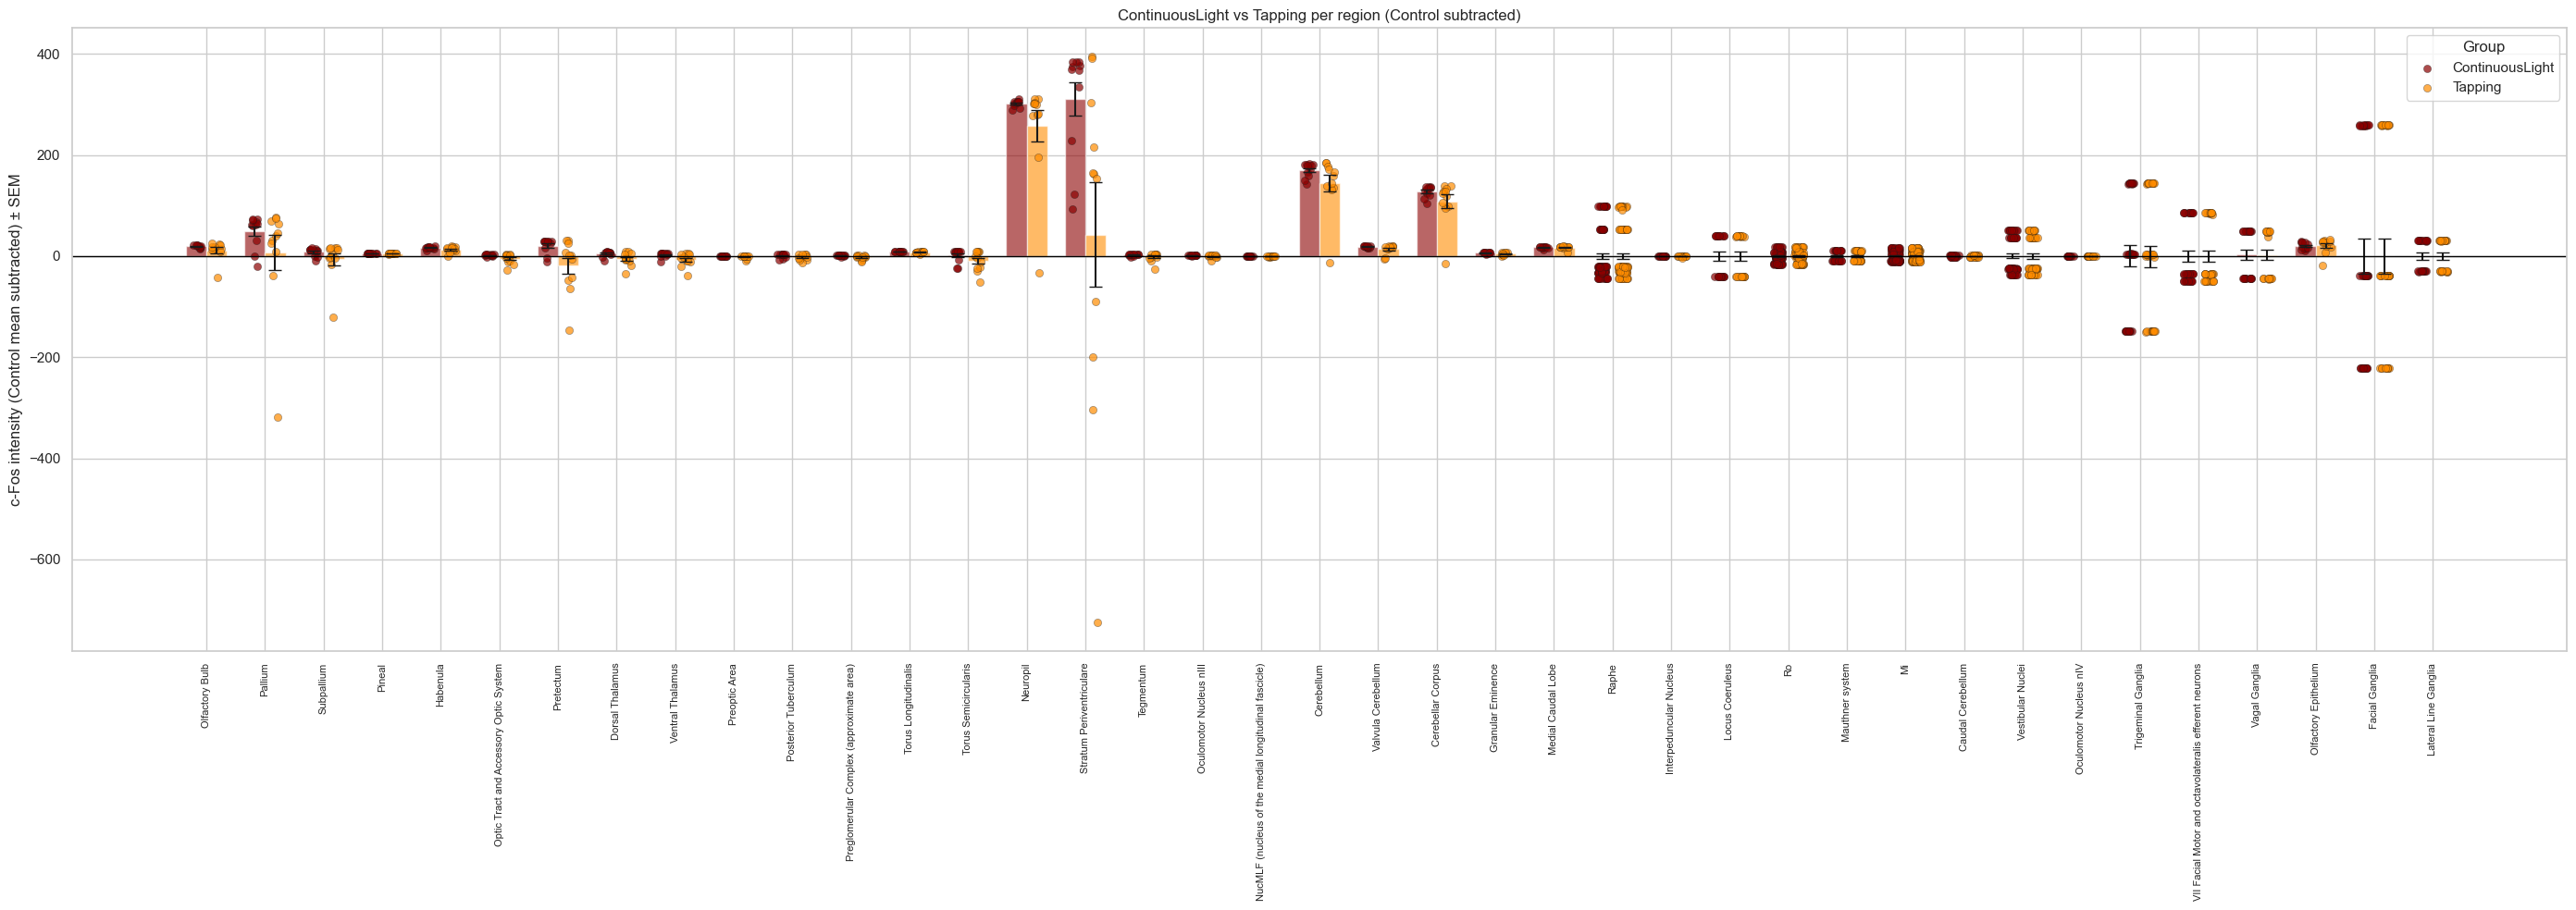

In [211]:
# ================================================================
# Mini masks: Control-subtracted, mixed model, contrasts + plot
# ================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem, norm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

# ------------------------
# Paths
# ------------------------
output_dir = r"E:\final\final\sleep_conditions_results"
os.makedirs(output_dir, exist_ok=True)

# ------------------------
# Subtract control mean per region
# ------------------------
control_means = (
    df_results[df_results['group'] == 'Control']
    .groupby('region')['cfos_intensity']
    .mean()
    .to_dict()
)

df_exp = df_results[df_results['group'].isin(['Tapping','ContinuousLight'])].copy()
df_exp['cfos_subtracted'] = df_exp.apply(
    lambda row: row['cfos_intensity'] - control_means.get(row['region'], 0), axis=1)

# ------------------------
# Mixed model with group × region
# ------------------------
model = smf.mixedlm(
    "cfos_subtracted ~ C(group)*C(region)",
    data=df_exp,
    groups=df_exp["fish_id"]
)
mixed_res = model.fit(reml=False)
print(mixed_res.summary())

# ------------------------
# Build contrasts: Tapping – ContinuousLight per region
# ------------------------
params = mixed_res.params
cov = mixed_res.cov_params()
param_names = params.index.tolist()

regions = df_exp['region'].unique()
contrast_list = []

for region in regions:
    L = np.zeros(len(params))

    # main effects
    tap_main = [i for i,p in enumerate(param_names) if p.startswith('C(group)[T.Tapping]')]
    cl_main  = [i for i,p in enumerate(param_names) if p.startswith('C(group)[T.ContinuousLight]')]
    for idx in tap_main: L[idx] = 1
    for idx in cl_main: L[idx] = -1

    # interaction terms for this region
    term_tap = [i for i,p in enumerate(param_names)
                if p == f'C(group)[T.Tapping]:C(region)[T.{region}]']
    term_cl  = [i for i,p in enumerate(param_names)
                if p == f'C(group)[T.ContinuousLight]:C(region)[T.{region}]']
    for idx in term_tap: L[idx] += 1
    for idx in term_cl:  L[idx] -= 1

    estimate = float(L @ params)
    se = float(np.sqrt(L @ cov @ L.T))
    t_stat = estimate/se if se>0 else np.nan
    p_val  = 2*(1-norm.cdf(abs(t_stat)))

    contrast_list.append({
        "region": region,
        "estimate_diff": estimate,
        "SE": se,
        "t_stat": t_stat,
        "p_value": p_val
    })

df_contrasts = pd.DataFrame(contrast_list)
df_contrasts['p_adj'] = multipletests(df_contrasts['p_value'], method='fdr_bh')[1]
df_contrasts['Significant'] = df_contrasts['p_adj'] < 0.05
df_contrasts.to_excel(os.path.join(output_dir, 'mini_region_contrasts.xlsx'), index=False)
print("Region-specific contrasts saved.")

# ------------------------
# Plot bars ± SEM + scatter (Control-subtracted)
# ------------------------
plot_order = df_exp['region'].unique()  # or use your anatomical_order if defined

x = np.arange(len(plot_order))
bar_width = 0.35
groups = ['ContinuousLight','Tapping']
palette = {'ContinuousLight':'#8B0000','Tapping':'#FF8C00'}
offsets = [-bar_width/2, bar_width/2]

plt.figure(figsize=(28,10))

for i, region in enumerate(plot_order):
    for j, group in enumerate(groups):
        vals = df_exp[(df_exp['region']==region) & (df_exp['group']==group)]['cfos_subtracted']
        if len(vals) == 0:
            continue

        # Bar with SEM
        plt.bar(x[i]+offsets[j], np.mean(vals), yerr=sem(vals), width=bar_width,
                color=palette[group], alpha=0.6, capsize=5)

        # Scatter points with jitter
        jitter = 0.08
        x_jitter = x[i] + offsets[j] + np.random.uniform(-jitter, jitter, len(vals))
        plt.scatter(x_jitter, vals, color=palette[group], alpha=0.7,
                    s=35, edgecolor='k', linewidth=0.3,
                    label=group if i==0 else "")

plt.xticks(x, plot_order, rotation=90, fontsize=8)
plt.ylabel("c-Fos intensity (Control mean subtracted) ± SEM")
plt.title("ContinuousLight vs Tapping per region (Control subtracted)")
plt.axhline(0, color='black', linewidth=1)
plt.legend(title='Group')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "mini_Continuous_vs_Tapping_subtracted.pdf"))
plt.show()
